In [1]:
# pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# import torch
# print(torch.rand(1, device="cuda"))
# !nvcc --version

In [3]:
!ls

data  results  sample_data


In [4]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [5]:
!ls

data  results  sample_data


In [6]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time

import argparse
from copy import deepcopy # Add Deepcopy for args

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)

print('현재 device :', device)

현재 device : cuda


# 1. model

In [9]:
class MLP(nn.Module):
    
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, batch_normal, dropout_p, weight_init):
        super(MLP,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer  # n_layer = hid_dim(1) + ... + hid_dim(n-1) + out_dim(n)
        self.act = act
        self.batch_normal = batch_normal
        self.dropout = dropout_p
        
        #===Create sequence space===#
        self.linears = nn.ModuleList()
        self.batch_normals = nn.ModuleList()
        
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        for idx in range(n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            # 레이어 마다 batch_normalization 시행 예정-> [linear - BN - activation] 반복
            if self.batch_normal == True:
                self.batch_normals.append(nn.BatchNorm1d(hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        #===Create Activation Function===#
        if self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        elif self.act == 'leaky_relu':
            self.act = nn.LeakyReLU()
        else:
            raise ValueError("no valid activation function selected(sigmoid, relu, leaky_relu, tanh)")
            
        #===Create Regularization layer===#
        # dropout
        self.dropout = nn.Dropout(self.dropout)
        # weight_initialization
        if weight_init == 'xavier':
            self.xavier_init()
        elif weight_init == 'he':
            self.he_init()
        else:
            raise ValueError("no valid weight_initializer selected(xavier, he)")
            
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
    
    def he_init(self):
        for linear in self.linears:
            torch.nn.init.kaiming_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
        
    def forward(self,x):
        out = self.act(self.fc1(x))
        
                                        #===hidden layer===#
        # 레이어 마다 batch_normalization 시행 예정-> [weight_init - linear - BN - activation - dropout] 반복
        # batch_norm, dropout 은 model.train()에서만 ON
        # batch_norm, dropout 은 hidden layer에서만 적용해야 함!
        for idx in range(len(self.linears)):
            out = self.linears[idx](out)
            if self.batch_normals:
                out = self.batch_normals[idx](out)
            out = self.act(out)
            out = self.dropout(out)
                                        #===hidden layer===#
        
        out = self.fc2(out)
        return out
  

In [10]:
# __init__(self, in_dim, out_dim, hid_dim, n_layer, act, batch_normal, dropout_p, weight_init):

model = MLP(3072,10,100,4,'leaky_relu',batch_normal=True,dropout_p=0.1,weight_init='he')

# 2. Train

In [11]:
def train(model, partition, optimizer, criterion, args):
    # input data preparation
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    model.train()
    
    train_loss = 0.0
    accuracy_batch = 0.0
    total_sample = 0 
    for i, samples in enumerate(trainloader):
        x_data, y_label = samples
        x_data = x_data.view(-1,3072)
        x_data = x_data.to(device)
        y_label = y_label.to(device)
        
        # forward
        output = model(x_data)
        cost = criterion(output, y_label)
        
        # backward
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        train_loss += cost.item()
        _, predicted_label = torch.max(output, dim=1)
        correct = predicted_label == y_label
        accuracy_batch += correct.float().sum().item()
        
        total_sample += y_label.size(0)
    
    
    # batch 당 평균 loss( len(trainloader) == batch 갯수 )
    train_loss_batch = train_loss / len(trainloader) 
    # 모든 sample의 평균 accuracy
    train_acc_batch = (accuracy_batch / total_sample)*100

    # 학습 후의 model을 return해서, 이후 validate 등에 넣어 활용할 예정
    return model, train_loss_batch, train_acc_batch
  

# 3. Validate

In [12]:
def validate(model, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    model.eval()
    
    val_loss = 0.0
    accuracy_batch = 0.0
    total_sample = 0
    with torch.no_grad():
        for samples in valloader:
            x_data, y_label = samples
            x_data = x_data.view(-1,3072)
            x_data = x_data.to(device)
            y_label = y_label.to(device)
            
            # forward
            output = model(x_data)
            cost = criterion(output, y_label)
            
            # backward (X)
            
            val_loss += cost.item()
            _, predicted_label = torch.max(output, dim=1)
            correct = predicted_label == y_label
            accuracy_batch += correct.float().sum().item()
            
            total_sample += y_label.size(0)
            
        val_loss_batch = val_loss / len(valloader) 
        val_acc_batch = (accuracy_batch / total_sample)*100
    
    return val_loss_batch, val_acc_batch

# 4. Test

In [13]:
def test(model, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    model.eval()
    
    accuracy_batch = 0.0
    total_sample = 0
    with torch.no_grad():
        for samples in testloader:
            x_data, y_label = samples
            x_data = x_data.view(-1,3072)
            x_data = x_data.to(device)
            y_label = y_label.to(device)
            
            # forward (X)

            # backward (X)
            
            output = model(x_data)
            _, predicted_label = torch.max(output, dim=1)
            correct = predicted_label == y_label
            accuracy_batch += correct.float().sum().item()
            
            total_sample += y_label.size(0)
            
        test_acc_batch = (accuracy_batch / total_sample)*100
    
    return test_acc_batch

# 5. Experiment

In [14]:
def experiment(partition,args):
    
    model = MLP(args.in_dim, args.out_dim, args.hid_dim,
                args.n_layer, args.act,
                args.batch_normal, args.dropout_p, args.weight_init)
    
    model.to(device)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr = args.lr, weight_decay = args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr = args.lr, weight_decay = args.l2)
    elif args.optim == 'ADAM':
        optimizer = optim.ADAM(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError("no valid optimizer selected(SGD, RMSprop, ADAM)")
        
    # Create loss, accuracy list for visualization(seaborn)
    # epoch-wise loss, accuracy
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # loop (train / val)
    for epoch in range(args.epoch+1):
        ts = time.time()
        
        model, train_loss_batch, train_acc_batch = train(model, partition, optimizer, criterion, args)
        val_loss_batch, val_acc_batch = validate(model, partition, criterion, args)
        
        te = time.time()
        
        train_losses.append(train_loss_batch)
        val_losses.append(val_loss_batch)
        train_accs.append(train_acc_batch)
        val_accs.append(val_acc_batch)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}.\
              Took {:2.2f} sec'.format(epoch, train_acc_batch, val_acc_batch, train_loss_batch, val_loss_batch, te-ts))
    
    test_acc_batch = test(model, partition, args)
    
    # to keep track of the result of each experiment
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc_batch
    result['val_acc'] = val_acc_batch
    result['test_acc'] = test_acc_batch
    
    # vars(object) : object가 갖는 attribute를 return! (result의 experiment arguments를 return하기 위함
    # vars(object) : object의 attribute를 dictionary 로 return!
    return vars(args), result

# 6. Manage Results as a File

In [15]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    # .updata : dictionary의 append와 같음 (result.update(setting) : result dict + setting dict)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# 7. Experiement 

In [16]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout_p = 0.2
args.batch_normal = True
args.l2 = 0.00001
args.weight_init = 'xavier'

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', batch_normal=True, dropout_p=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, weight_init='xavier')
Epoch 0, Acc(train/val): 37.64/36.05, Loss(train/val) 2.53/1.98.              Took 10.28 sec
Epoch 1, Acc(train/val): 45.94/39.42, Loss(train/val) 1.57/1.77.              Took 10.38 sec
Epoch 2, Acc(train/val): 49.04/39.26, Loss(train/val) 1.50/1.98.              Took 10.36 sec
Epoch 3, Acc(train/val): 51.03/39.14, Loss(train/val) 1.43/1.87.              Took 10.39 sec
Epoch 4, Acc(train/val): 52.80/41.36, Loss(train/val) 1.38/1.94.              Took 10.37 sec
Epoch 5, Acc(train/val): 54.77/46.57, Loss(train/val) 1.34/1.68.              Took 10.32 sec
Epoch 6, Acc(train/val): 56.52/46.96, Loss(train/val) 1.28/1.68.              Took 10.33 sec
Epoch 7, Acc(train/val): 58.31/47.85, Loss(train/val) 1.24/1.61.              Took 10.37 sec
Epoc

# 8. Visualize

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


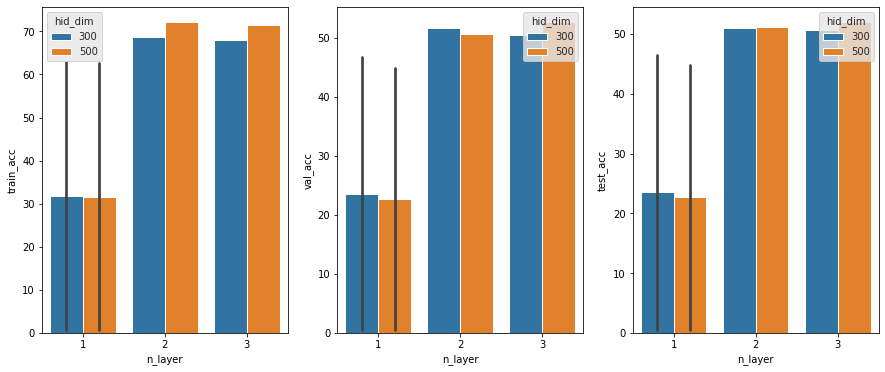

In [17]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

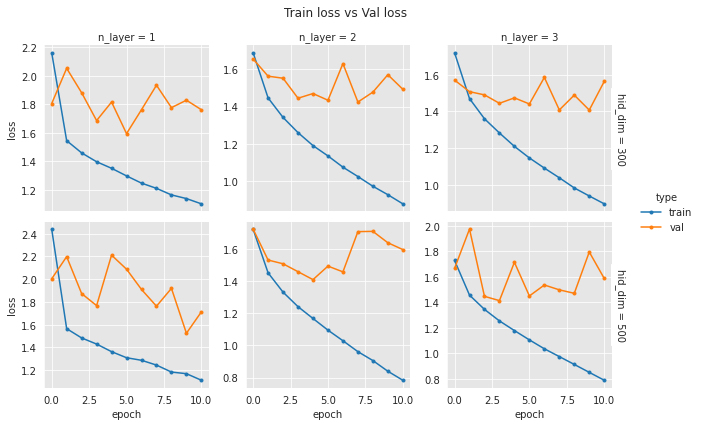

In [18]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

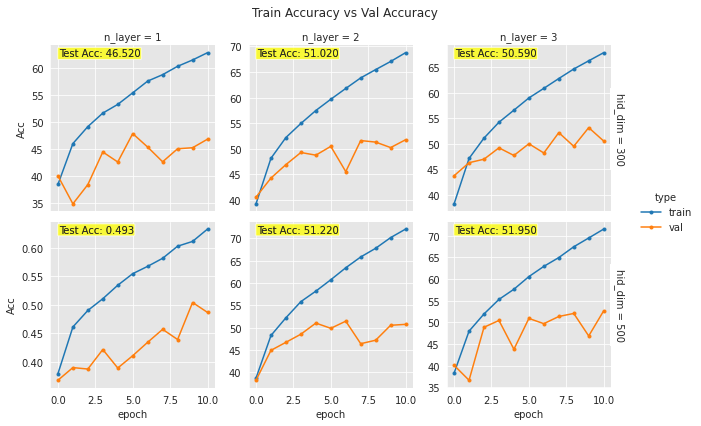

In [19]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)